# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

# Lightning Module

In [2]:
MINI_DATA = True  # True if used for testing purposes

attr.s(repr=False)
class CatBoost(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 8, 20)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_intentional",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = now - timedelta(days=365 * 5),
            trainval_end    = now - timedelta(days=61),
            
            # Backtest Optimization datetime
            opt_start = now - timedelta(days=60),
            opt_end   = now - timedelta(days=31),
            
            # Unbiased Backtest datetime
            test_start = now - timedelta(days=30),
            test_end   = now,
            
            # Num training epochs
            num_training_epochs = 100,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "CPU")
        config.add_custom("learning_rate", 0.002)
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        df_onepair['ml_next_close'] = (future_price - df_onepair['close']) / df_onepair['close']
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        train = df_allpairs[df_allpairs["date"] < val_split_date]
        val = df_allpairs[df_allpairs["date"] >= val_split_date]
        
        X_train = train[self.config.columns_x]
        X_val = val[self.config.columns_x]
        y_train = train[self.config.column_y]
        y_val = val[self.config.column_y]
        
        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=25,
        )
        print("Accuracy: %.2f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoost()

# Dataset EDA Before Training

In [3]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(module)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

Load and preprocess data:   0%|          | 0/5 [00:00<?, ?it/s]

,ml_next_close,ml_label
123338,-0.003629,1.0
123339,-0.004145,1.0
123340,0.000650,2.0
123341,-0.000260,2.0
123342,-0.006045,0.0


In [4]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): []
Dataset Length: 558699
Date Min: 2017-08-17 04:00:00+00:00
Date Max: 2021-06-19 23:00:00+00:00


<AxesSubplot:>

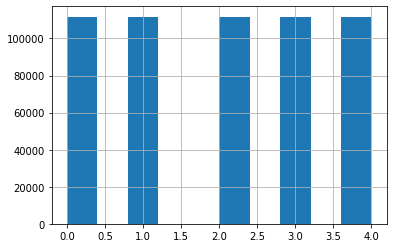

In [5]:
df_["ml_label"].hist()

In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558699 entries, 0 to 123342
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ml_next_close  558699 non-null  float32
 1   ml_label       558699 non-null  float32
dtypes: float32(2)
memory usage: 8.5 MB


In [7]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [8]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

freqtrade.ml.trainer - Validating model using mini training...


Load and preprocess data:   0%|          | 0/1 [00:00<?, ?it/s]

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6015000	test: 1.6014842	best: 1.6014842 (0)	total: 186ms	remaining: 1.67s
9:	learn: 1.5337239	test: 1.5335041	best: 1.5335041 (9)	total: 445ms	remaining: 0us

bestTest = 1.533504108
bestIteration = 9

Accuracy: 1.00
freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns
freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']

PASSED: The model passed the validation test!
freqtrade.ml.trainer - Validate model OK!


Load and preprocess data:   0%|          | 0/5 [00:00<?, ?it/s]

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6028460	test: 1.6025409	best: 1.6025409 (0)	total: 115ms	remaining: 11.4s
25:	learn: 1.4556983	test: 1.4490812	best: 1.4490812 (25)	total: 2.82s	remaining: 8.02s
50:	learn: 1.3348622	test: 1.3234887	best: 1.3234887 (50)	total: 5.55s	remaining: 5.33s
75:	learn: 1.2330793	test: 1.2180198	best: 1.2180198 (75)	total: 8.26s	remaining: 2.61s
99:	learn: 1.1489356	test: 1.1308014	best: 1.1308014 (99)	total: 10.9s	remaining: 0us

bestTest = 1.130801379
bestIteration = 99

Accuracy: 0.94


# Predictions EDA

In [9]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']



Dataset: Binance BTC/USDT 15m iloc[-10000:] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 131026 to 141025
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    10000 non-null  datetime64[ns, UTC]
 1   open    10000 non-null  float64            
 2   high    10000 non-null  float64            
 3   low     10000 non-null  float64            
 4   close   10000 non-null  float64            
 5   volume  10000 non-null  float64            
 6   ml_0    9998 non-null   float64            
 7   ml_1    9998 non-null   float64            
 8   ml_2    9998 non-null   float64            
 9   ml_3    9998 non-null   float64            
 10  ml_4    9998 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10)
memory usage: 937.5 KB
None


DF Original
----------
                            date      open  

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4
131026,2021-05-13 00:30:00+00:00,49711.83,50630.00,49578.94,49896.61,5110.913916,0.163552,0.163552,0.163551,0.169379,0.339966
131027,2021-05-13 00:45:00+00:00,49896.15,50324.72,49581.44,49666.99,2389.969100,0.163552,0.163552,0.163551,0.169379,0.339966
131028,2021-05-13 01:00:00+00:00,49661.12,50600.00,49305.43,50191.47,3869.211034,0.340933,0.168320,0.163582,0.163582,0.163582
131029,2021-05-13 01:15:00+00:00,50191.47,50437.86,49972.44,50324.12,2755.398561,0.164106,0.164106,0.166398,0.311481,0.193909
131030,2021-05-13 01:30:00+00:00,50314.99,50374.48,49665.94,49889.82,2116.566505,0.163552,0.163552,0.163551,0.169379,0.339966
...,...,...,...,...,...,...,...,...,...,...,...
141021,2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,0.340933,0.168320,0.163582,0.163582,0.163582
141022,2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,0.163974,0.192100,0.312221,0.167730,0.163974
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.163440,0.168113,0.334712,0.170296,0.163439
141024,2021-08-25 04:00:00+00:00,47975.93,48245.00,47940.02,48155.56,275.930495,NaN,NaN,NaN,NaN,NaN


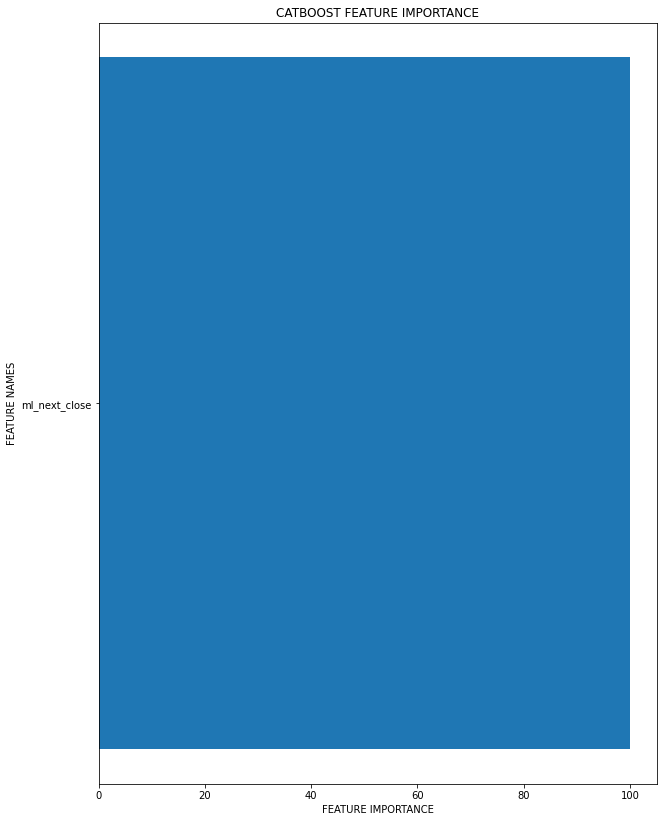

In [10]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'CATBOOST')

# Backtesting: Model Validation (Must Profitable)

In [ ]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_classes = lightning_container.config.num_classification_classes
            dataframe = lightning_container.predict(dataframe)
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            
            # self.print_once(dataframe.info(), "info_df")
            # self.print_once(dataframe.describe(), "describe_df")
            # self.print_once(dataframe, "populate_buy_sell")
            
            return dataframe
    """ End Strategy Code """

MODEL_NAME = "15n30-catboost_intentional"
MODEL_VER = "latest"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Strategy Optimization

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 5 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 5 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_opt_15n30-catboost_intentional ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210621-20210720
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210621-20210720 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking e

You are using LATEST (v2) of '15n30-catboost_intentional'


INFO:freqtrade.resolvers.exchange_resolver:Using resolved exchange 'Binance'...
INFO:freqtrade.configuration.config_validation:Validating configuration ...
INFO:freqtrade.resolvers.iresolver:Using resolved pairlist StaticPairList from 'C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\plugins\pairlist\StaticPairList.py'...
INFO:freqtrade.nbtools.backtest:Backtesting...
INFO:freqtrade.nbtools.backtest:DATALOADER: Dataset with hash `9127136464604545492` exists in cache!
INFO:freqtrade.nbtools.helper:"Load BT Data" executed in 0.01s
INFO:freqtrade.nbtools.backtest:Loading data from 2021-06-10 14:00:00 up to 2021-07-20 00:00:00 (39 days).
INFO:freqtrade.nbtools.backtest:Dataload complete. Calculating indicators
INFO:freqtrade.optimize.backtesting:Running backtesting for Strategy NotebookStrategy


Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']
INFO:freqtrade.optimize.backtesting:Backtesting with data from 2021-06-15 19:00:00 up to 2021-07-20 00:00:00 (34 days).
INFO:freqtrade.nbtools.helper:"Backtest" executed in 0.62s
INFO:freqtrade.nbtools.backtest:Logging preset...
INFO:freqtrade.nbtools.backtest:[LOG PRESET OFFLINE SUCCESS]
INFO:freqtrade.nbtools.backtest:Sync preset with name: ml_opt_15n30-catboost_intentional__backtest-2021-09-03_14-28-09
INFO:freqtrade.nbtools.backtest:with random name: friendly-vivy-cpu
INFO:freqtrade.nbtools.backtest:[WANDB LOG PRESET CONTINUES IN BACKGROUND]
INFO:freqtrade.nbtools.helper:"Whole Backtesting Process (Backtest + Log)" executed in 1.75s


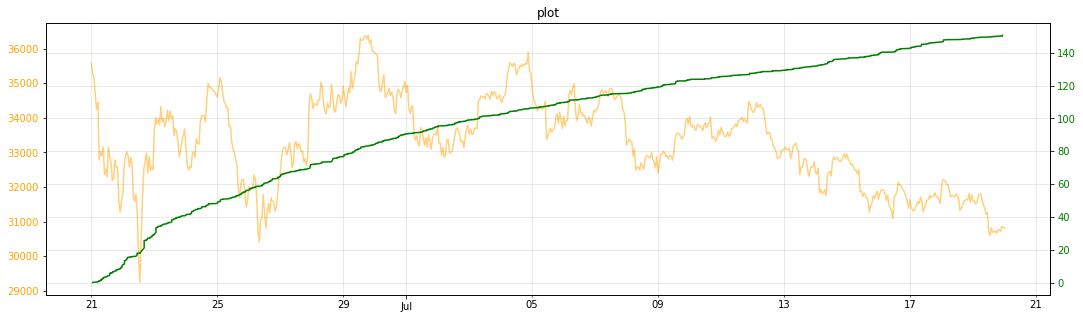

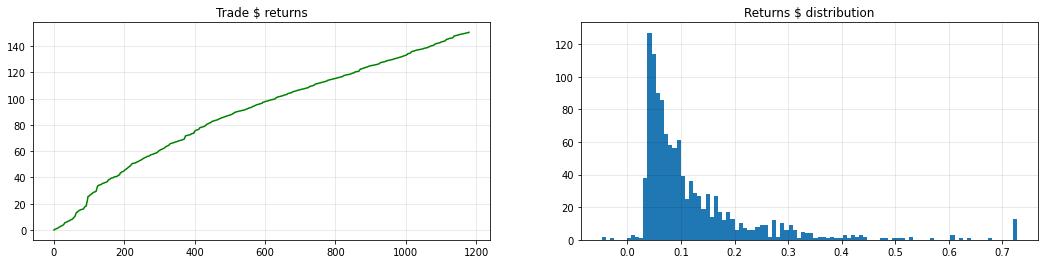

,Portfolio Summary
Trades,1181
Avg. Stake Amount,15.0
Number of Pairs,4
Min Balance,0.08
Max Balance,150.58
Final Balance,150.58
-,-
Wins,1177
Loses,4
Win Rate,100.0%


In [13]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = 5
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                # dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                # dataframe['ml_4'] > 0.65,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Final Phase

INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_opt_15n30-catboost_intentional__backtest-2021-09-03_14-28-09'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 5 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 5 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_test_15n30-catboost_intentional ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210721-20210820
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210721-20210820 ...
INFO:freqtrade.configur

You are using LATEST (v2) of '15n30-catboost_intentional'


INFO:freqtrade.resolvers.exchange_resolver:Using resolved exchange 'Binance'...
INFO:freqtrade.configuration.config_validation:Validating configuration ...
INFO:freqtrade.resolvers.iresolver:Using resolved pairlist StaticPairList from 'C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\plugins\pairlist\StaticPairList.py'...
INFO:freqtrade.nbtools.backtest:Backtesting...
INFO:freqtrade.nbtools.backtest:DATALOADER: Dataset with hash `-4940870109391995272` doesn't exist. Loading from disk...
INFO:freqtrade.data.history.history_utils:Using indicator startup period: 1000 ...
INFO:freqtrade.nbtools.helper:"Load BT Data" executed in 1.11s
INFO:freqtrade.nbtools.backtest:Loading data from 2021-07-10 14:00:00 up to 2021-08-20 00:00:00 (40 days).
INFO:freqtrade.nbtools.backtest:Dataload complete. Calculating indicators
INFO:freqtrade.optimize.backtesting:Running backtesting for Strategy NotebookStrategy


Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']
INFO:freqtrade.optimize.backtesting:Backtesting with data from 2021-07-15 19:00:00 up to 2021-08-20 00:00:00 (35 days).
INFO:freqtrade.nbtools.helper:"Backtest" executed in 1.79s
INFO:freqtrade.nbtools.backtest:Logging preset...
INFO:freqtrade.nbtools.backtest:[LOG PRESET OFFLINE SUCCESS]
INFO:freqtrade.nbtools.backtest:Sync preset with name: ml_test_15n30-catboost_intentional__backtest-2021-09-03_14-28-32
INFO:freqtrade.nbtools.backtest:with random name: disgusted-todoroki-charger
INFO:freqtrade.nbtools.backtest:[WANDB LOG PRESET CONTINUES IN BACKGROUND]
INFO:freqtrade.nbtools.helper:"Whole Backtesting Process (Backtest + Log)" executed in 2.90s


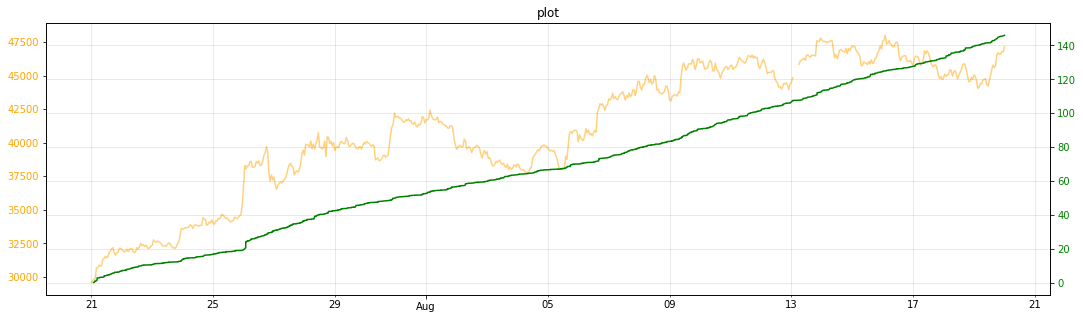

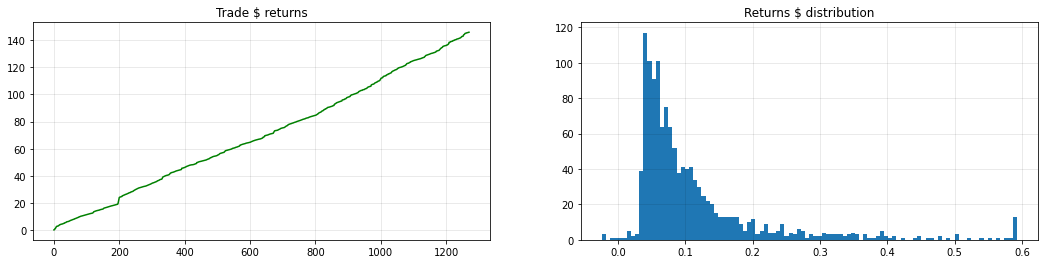

,Portfolio Summary
Trades,1271
Avg. Stake Amount,15.0
Number of Pairs,4
Min Balance,0.04
Max Balance,145.95
Final Balance,145.95
-,-
Wins,1266
Loses,5
Win Rate,100.0%


INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_test_15n30-catboost_intentional__backtest-2021-09-03_14-28-32'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================


In [14]:
"""
This is a phase where you believe your strategy is now optimized with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)